### Student:Rickard Sörlin

- I did not request a formal review for this lab, so there was no feedback to incoperate.

- AI tools like GitHub Copilot and ChatGPT were used as support to understand the existing code provided in notebooks like functions,arguments and methods
and to get a deeper explaination of concepts. They were also used whern i got stuck, needed to complete missing parts, or ecountered unexpected errors.

- Through the lab, I made sure I understood the suggestions i recieved before applying them. Using AI support helped improve my learning, since it encouraged me to ask follow-up questions such why a specific argument or methods was used and what alternatives could work. I then adapted the suggestions to fit my own solution.




# Lab 3: Pretraining a GPT model

This lab is about pretraining large language models (LLMs). You will work through the full pretraining process for a GPT model, explore different settings, and implement optimisations that make training more efficient. You will also reflect on the impact of data curation on the quality of the pretrained model. By the end of the lab, you will have a solid understanding of how LLMs are trained from scratch.

*Tasks you can choose for the oral exam are marked with the graduation cap 🎓 emoji.*

In [1]:
import math
import os
import time
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from gpt2 import Config, Model

## Part 1: Pretraining pipeline

The GPT pretraining pipeline builds on the basic training loop for neural language models you have seen before, but includes several enhancements that improve stability and efficiency when training large models:

* It uses the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) optimiser with weight decay instead of vanilla stochastic gradient descent.
* It implements a cosine decay learning rate schedule with a linear warmup phase.
* It accumulates gradient updates across multiple batches to allow training with larger effective batch sizes.
* It uses gradient clipping to prevent exploding gradients.

### Training configuration

We begin by setting up a configuration object that defines the key parameters of the training process. The original 124M-parameter GPT-2 model was trained on WebText, a private dataset with approximately 10B tokens of Internet data. (There is no reliable public source that reports the exact number.) Our training pipeline is configured to train a Chinchilla-optimal version of the same model using the [FineWeb-Edu](https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu) dataset and a single A100 GPU with 80GB of memory.

In [2]:
@dataclass
class TrainingConfig:
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    shard_dir: str = "data"

    # Training steps and data processing
    n_steps: int = 4768
    n_tokens_per_step: int = 524288
    batch_size: int = 4 # org 64
    sequence_len: int = 1024 #1024
    n_vocab: int = 50304

    # Optimisation and learning rate scheduling
    weight_decay: float = 0.1
    max_lr: float = 6e-4
    min_lr: float = 6e-5
    n_warmup_steps: int = 715
    n_decay_steps: int = 4053
    betas: tuple[float, float] = (0.9, 0.95)
    clip_norm: float = 1.0

#### 🎓 Task 3.01: Explaining the training parameters

Your first task is to explain the purpose of the training parameters. Some of them will already be known to you from the lectures, while others will become clear first as you progress through the lab and see how everything fits together. Because of this, it is best to revisit and complete this task towards the end of the lab when you have a full understanding of the training process.

One parameter to note is the vocabulary size. GPT-2 uses 50,257 tokens, but for training on a GPU, it is helpful to have numbers that are more hardware-friendly. Specifically, numbers with many factors of&nbsp;2 can lead to more efficient computation. To achieve this, we set the vocabulary size to 50,304, which is slightly larger than needed but has many factors of&nbsp;2. Note that the extra tokens will not be used in practice — they simply act as placeholders without meaningful embeddings.


##    device:
###     Is away to tell where the model should be running CPU/CUDA/mps
##    shard_dir: 
###   Path to the directory where the data from FineWeb is located for training.

##    # Training steps and data processing
##    n_steps:
###   It holds information on how many weight update todo
##    n_tokens_per_step: 
###   It holds information how many tokens will be processed for each optimazation step
##    batch_size:
###   Its amount of sequences for each micro batch
##    sequence_len:
###   Its holds information about the sequnce length, meaning amount of tookens per row  
##    n_vocab:
###   It the the model vocabulary size in this case 50304 

##    Optimisation and learning rate scheduling
##    weight_decay: 
###   Its a reularization technich that helpt prevent overfitting and tried minimize the weights during training. 
##    max_lr:
###   Its maximum learning rate  the scheduler reaches  warm up
##    min_lr:
###   Its for the minimum value that the scheduler decays to at the end of cosine decay 
##    n_warmup_steps:
###   It tells how many warm up steps it will take at beginning of training to more gentle investigate the parameter space and do small changes as beginning and then increase.
##    n_decay_steps:
###   It tells how many steps it will take after the warm up and start with cosine decay and decrease the size of changes from max_lr to min_lr during each step to have a more dynamc change of learning rate and controlled
##    betas:
###  It hold the hyperparameters Beta1,Beta2 for AdamW Beta1 that controls the momentum of the learning
##    clip_norm:
###  It is for preventing exploding gradients.

### Model

Next, we set up the GPT model. Our goal is to match the original training setup of GPT-2 as closely as possible. To do this, we follow the initialisation strategy outlined in the key research papers about GPT ([Radford et al., 2018](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf); [Radford et al., 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf); [Brown et al., 2020](https://arxiv.org/pdf/2005.14165)) as well as the official implementation ([link](https://github.com/openai/gpt-2)). Here is a summary of this strategy:

* Token embeddings → Normal distribution with mean $0$ and standard deviation $0.02$.
* Position embeddings → Normal distribution with mean $0$ and standard deviation $0.01$.
* Weights of the linear layers → Normal distribution with mean $0$ and standard deviation $0.02$.
* Biases of the linear layers → Initialised to zeros.
* Weight sharing between the final linear layer and the token embedding.

#### 🎈 Task 3.02: Initialising the model

Expand the skeleton code below to create a fresh model and initialise it according to the GPT-2 strategy.

In [3]:

def configure_model(config: TrainingConfig) -> Model:
    # TODO: Replace the following line with your own code

    # create and return the model
    model = Model(Config(n_vocab=config.n_vocab))
    
    
    layers = model.config.n_layer
    N = 2*layers
    scale = 1 / math.sqrt(N)
    
    # set model token embeddings → Normal distribution with mean 0 and standard deviation 0.02  
    model.wte.weight.data.normal_(mean=0.0, std=0.02)
    #Position embeddings → Normal distribution with mean 0 and standard deviation 0.01
    model.wpe.weight.data.normal_(mean=0.0, std=0.01)
    
    for name,layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            layer.weight.data.normal_(mean=0.0, std=0.02)
            if layer.bias is not None:
                layer.bias.data.zero_()
            
            if name.endswith("c_proj"):
                layer.weight.data.mul_(scale)
    
    model.lm_head.weight = model.wte.weight
    
   
            
    
    return model

In [4]:
config = TrainingConfig()

# create and return the model
model = Model(Config(n_vocab=config.n_vocab))
model

Model(
  (wte): Embedding(50304, 768)
  (wpe): Embedding(1024, 768)
  (h): Sequential(
    (0): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=True)
        (c_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (1): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=True)
        (c_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Linear(in_features=768, out_features=3072, bias=T

#### Scaled residual initialisation

There is one important detail in the GPT-2 initialisation strategy that we have not addressed yet. [Radford et al. (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) write (Section&nbsp;2.3):

> A modified initialization which accounts for the accumulation on the residual path with model depth is used. We scale the weights of residual layers at initialization by a factor of $1/\sqrt{N}$ where $N$ is the number of residual layers.

Why is this necessary? One of the challenges in training large language models is controlling the variance of activations. However, there are two points in the GPT architecture where variance can grow uncontrollably: the residual connections after the multi-head attention and the MLP. Since these connections simply add activations from previous layers, their variances increase with depth. To see this, note that if we sum $N$ independent normally distributed variables with variance $\sigma^2$, the result has variance $N \sigma^2$. The factor $1/\sqrt{N}$ compensates for this growth.

#### 🎓 Task 3.03: Implementing the scaled residual initialisation

**Step&nbsp;1.** Suppose each summand in a sum of $N$ independent normally distributed variables with variance $\sigma^2$ is scaled by a factor of&nbsp;$k$. The total variance then becomes $N k^2 \sigma^2$. What happens to the total variance if we choose $k = 1/\sqrt{N}$, as in GPT-2?


**Step&nbsp;2.** Test the mathematical theory with a simulation. Generate normally distributed activations using `torch.randn()`. Sum the activations across $N$ hypothetical residual layers, first without scaling and then with the $1/\sqrt{N}$ adjustment. Compare the two cases by producing a plot showing the variance at each layer. To compute the variance of a tensor, use `torch.var()`.

**Step&nbsp;3.** Update your model initialisation from the previous task to include the scaled residual initialisation. The adjustment should only be applied to the linear layer at the end of the multi-head attention and MLP blocks (`c_proj`). Note that a GPT model with $L$&nbsp;layers has $N = 2 L$ residual layers, because there are two residual connections in each layer (after the multi-head attention and the MLP).

## Step 1 

$N k^2 \sigma^2$

$k = 1/\sqrt{N}$

######################

$N (1/\sqrt{N})^2 \sigma^2$

$N (1/\N) \sigma^2$

$\sigma^2$

### Answer the total variance will be $\sigma^2$

### Data

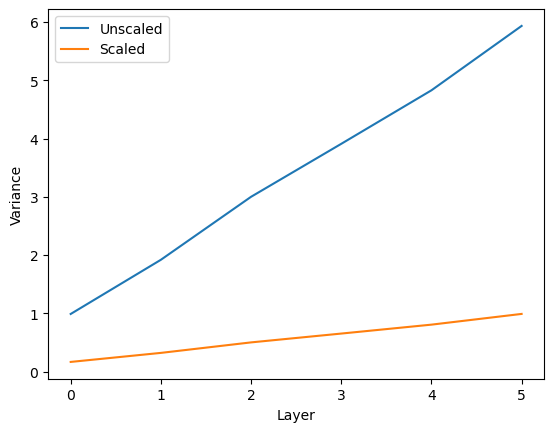

In [5]:
# Step 2
import matplotlib.pyplot as plt

layers = 6
neurons = 1024
X = torch.randn(layers, neurons)

unscaled = X.cumsum(dim=0)
scaled   = (X / math.sqrt(layers)).cumsum(dim=0)
var_unscaled = unscaled.var(dim=1)
var_scaled   = scaled.var(dim=1)
plt.plot(var_unscaled.numpy(), label="Unscaled")
plt.plot(var_scaled.numpy(), label="Scaled")
plt.xlabel("Layer")
plt.ylabel("Variance")
plt.legend()
plt.show()


As mentioned before, GPT-2 was pretrained on a 10B-token non-public dataset collected by OpenAI. Our pretraining data comes from the public [FineWeb-Edu](https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu) dataset. The full dataset contains 1.3&nbsp;trillion tokens, but in this lab, we will only work with a tiny sample. We have preprocessed the data by tokenising it with the GPT-2 tokeniser and storing the token indices in equal-sized NumPy arrays, which we call **shards**. The function below loads these shards from a given directory and yields them as PyTorch tensors.

In [6]:
def shards(shard_dir: str):
    for shard in sorted(os.listdir(shard_dir)):
        yield torch.from_numpy(np.load(os.path.join(shard_dir, shard)).astype(np.int64))

In total, our training data consists of 300M tokens:

In [7]:
sum(s.numel() for s in shards(TrainingConfig().shard_dir))

300000000

#### 🎓 Task 3.04: Batching the data

Implement a function `make_batches()` that packages the token indices in the shards into pairs of input and output batches suitable for language modelling training. One efficient way to do this is sketched in the cell below:

In [8]:
shard = torch.tensor(range(15), dtype=torch.long)

# Suppose we want to package the tokens in this shard into batches of shape (2, 3).

# Step 1: Segment the shard into overlapping chunks of size 2 * 3 + 1
chunk1 = shard[0:7]
chunk2 = shard[6:13]
excess = shard[12:]

# Step 2: Create batches from all but the last and all but the first token in each chunk
x1, y1 = chunk1[:-1].view(2, 3), chunk1[1:].view(2, 3)
x2, y2 = chunk2[:-1].view(2, 3), chunk2[1:].view(2, 3)

The following code cell shows the signature of `make_batches()`.

In [4]:
sum(1 for s in make_batches(TrainingConfig()))

NameError: name 'make_batches' is not defined

In [ ]:
def make_batches(config: TrainingConfig):
    batch_size = config.batch_size
    sequence_len = config.sequence_len
    need = batch_size * sequence_len + 1  
    step = batch_size * sequence_len      

    carry = torch.empty(0, dtype=torch.long)  

    for shard in shards(config.shard_dir):
        buf = torch.cat((carry, shard)) if carry.numel() else shard  

        i = 0
        while i + need <= buf.numel():
            chunk = buf[i : i + need]
            x = chunk[:-1].view(batch_size, sequence_len)
            y = chunk[1:].view(batch_size, sequence_len)
            yield x, y
            i += step

        # behåll sista need-1 tokens som svans till nästa shard
        carry = buf[-(need - 1):] if buf.numel() >= need - 1 else buf
    # ev. spill (< need) droppas automatiskt


In [11]:
batch = make_batches(TrainingConfig())

x,y = next(batch)
x.shape, y.shape

(torch.Size([4, 1024]), torch.Size([4, 1024]))

**Hints and considerations:**

* Batches can stretch across shards. You will have to carry over excess tokens at the end of shards to the next batch.
* All batches should have the same shape. Drop excess tokens at the end of the last shard.
* The correct number of batches of shape $(64, 1024)$ for the training shards is $4577$.

### Optimiser

The code in the cell below configures the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) optimiser. It uses weight decay on all parameters with two or more dimensions (e.g., weights in linear layers), and no decay on the remaining parameters. If the model is on a CUDA device, the code uses the “fused” implementation of the optimiser for efficiency.

In [12]:
def configure_optimizer(model: Model, config: TrainingConfig):
    params = [p for p in model.parameters() if p.requires_grad]
    decay_params = [p for p in params if p.dim() >= 2]
    no_decay_params = [p for p in params if p.dim() < 2]
    param_groups = [
        {"params": decay_params, "weight_decay": config.weight_decay},
        {"params": no_decay_params, "weight_decay": 0.0},
    ]
    return torch.optim.AdamW(
        param_groups,
        lr=config.max_lr,
        betas=config.betas,
        fused=(config.device.type == "cuda"),
    )

#### 🎓 Task 3.05: Exploring the beta parameters

The AdamW optimiser is controlled by two hyperparameters $\beta_1$ and $\beta_2$:

* $\beta_1$ controls the moving average of past gradients.
* $\beta_2$ controls the moving average of past squared gradients, which affects the adaptive learning rate scaling.

Lower values correspond to reduced effect of the respective average, that is, less smoothing and faster adaptation to recent values. In this task, you will explore how different beta values affect the convergence behaviour of the optimiser.

The code below applies the optimiser to the function $f(x) = (x-2)^2 + (y+3)^2$, which has a global minimum at $(2, -3)$. The code yields the trajectories of the parameter values $(x, y)$ visited by Adam when started at $(-4, 5)$ for different values of&nbsp;$\beta_1$ and $\beta_2$.

In [13]:
def adam_trajectories(betas):
    def loss_function(x, y):
        return (x - 2) ** 2 + (y + 3) ** 2

    for beta1, beta2 in betas:
        x = torch.tensor([-4.0], requires_grad=True)
        y = torch.tensor([5.0], requires_grad=True)
        optimizer = torch.optim.AdamW((x, y), lr=0.125, betas=(beta1, beta2))
        trajectory = []
        for _ in range(100):
            optimizer.zero_grad()
            loss = loss_function(x, y)
            loss.backward()
            optimizer.step()
            trajectory.append((x.item(), y.item()))
        yield trajectory, f"β₁ = {beta1}, β₂ = {beta2}"

 Your task is to visualise different trajectories in a plot and analyse the results. Proceed as follows:

* Start by plotting the trajectory for the default values for $\beta_1$ and $\beta_2$. (Consult the PyTorch documentation to find these.)
* Add the plot for the beta values used in our training configuration. For this simple example, do you see a significant difference?
* Add more plots to see what happens if the beta values are too high or too low.

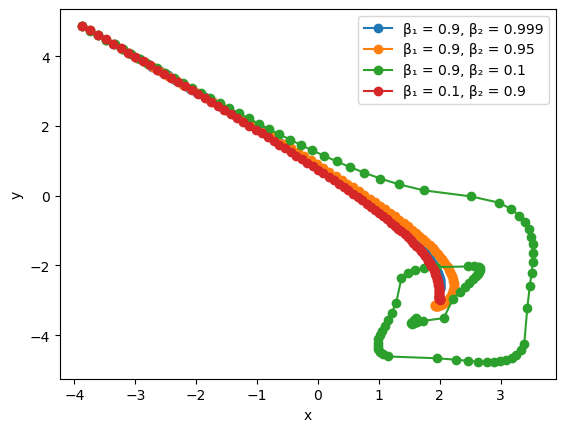

In [14]:

trajectories = adam_trajectories(betas=[(0.9, 0.999),(0.9, 0.95),(0.9, 0.1),(0.1, 0.9)])

for trajectory, label in trajectories:
    xs, ys = zip(*trajectory)
    plt.plot(xs, ys, marker="o" , label=label)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Learning rate scheduling

Your next task is to implement the learning rate scheduler. As mentioned before, GPT-2 is trained with cosine decay from a maximum to a minimum learning rate in conjunction with a linear warmup phase.

#### 🎓 Task 3.06: Implementing cosine decay

Implement a function `get_lr_factor()` that determines the learning for a given `step`. To work with the rest of the implementation, this function should return its result as a factor of the maximum learning rate. In particular, the result at the end of the linear warmup should be&nbsp;$1$. Validate your implementation by plotting the function against the training steps.

In [ ]:
def get_lr_factor(step: int, config: TrainingConfig) -> float:
    warmup_steps = config.n_warmup_steps
    decay_steps = config.n_decay_steps
    min_factor = config.min_lr / config.max_lr
    
    # warmining up investigate carefully the parameter space
    if warmup_steps > 0 and step < warmup_steps:                    # warmup phase
        return step / warmup_steps                                  # at end will be 1.0 
    
    if decay_steps == 0: #                                          no decay
        return 1.0
  
    if step < warmup_steps + decay_steps:                           # decay phase
        x = (step - warmup_steps) / decay_steps                     # normalized step in [0,1]
        cosine_decay = 0.5 * (1 + math.cos(math.pi * x))            # cosine decay
        return min_factor + (1 - min_factor) * cosine_decay         # return decayed value
    
    return min_factor

            

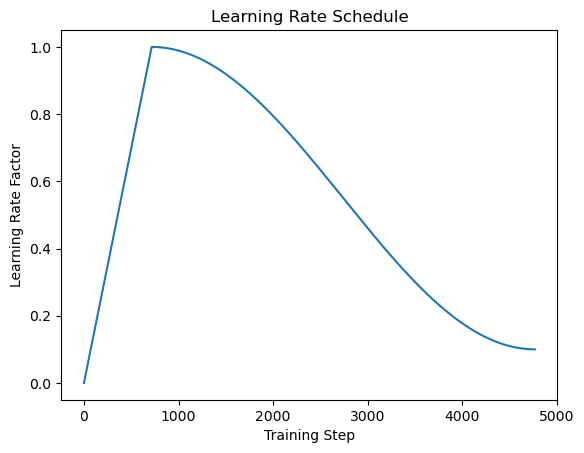

In [17]:
cfg = TrainingConfig()
      
steps = range(cfg.n_steps)
lr_factors = [get_lr_factor(step, cfg) for step in steps]
plt.plot(steps, lr_factors)
plt.xlabel("Training Step")
plt.ylabel("Learning Rate Factor")
plt.title("Learning Rate Schedule")
plt.show()

**Hint:** For $x \in [0, 1]$, the relevant cosine decay is described by the term $\frac{1}{2} \cdot (1 + \text{cos}(\pi x))$.

### Training loop

At this point, we have everything in place to put together a first version of the training loop. Here it is:

In [ ]:
def train(config: TrainingConfig):
    model = configure_model(config)
    model = model.to(config.device)
    #model = torch.compile(model)
    batches = make_batches(config)
    optimizer = configure_optimizer(model, config)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda lr: get_lr_factor(lr, config),
    )
    n_micro_steps = config.n_tokens_per_step // (
        config.batch_size * config.sequence_len
    )
    tokenscounter = 0
    for step in range(config.n_steps):
        model.train()
        optimizer.zero_grad()
        running_loss = 0.0
        
        timestart = time.time()
        for micro_step in range(n_micro_steps):
            x, y = next(batches)
            x, y = x.to(config.device), y.to(config.device)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), reduction="sum") 
            loss = loss / config.n_tokens_per_step # normalise  sum of loss over total tokens
            loss.backward()
            running_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm)
        optimizer.step()
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
        
        if config.device.type == "mps":
            torch.mps.synchronize()
        elif config.device.type == "cuda":
            torch.cuda.synchronize()
        stoptime = time.time() -  timestart
        tokens_per_second = config.n_tokens_per_step / stoptime
        
        tokenscounter += config.n_tokens_per_step
        
        print(f"step {step:4d} | loss: {running_loss:.4f} | lr: {lr:.4e} |" 
              f"speed: {tokens_per_second:.2f} tokens/s |"
              f"Total tokens processed: {tokenscounter}"
              )

Most of the steps should look familiar from previous labs or earlier tasks in this notebook. However, a few key aspects will be new:

**Moving the model and data to the training device.** The model and each batch are moved to the training device using `.to()`. In our training configuration, `config.device` is an NVIDIA GPU, which supports fast tensor computations.

**Gradient accumulation.** Instead of taking an optimisation step after every batch, we accumulate gradients over multiple batches (“micro-steps”). Each batch contributes to the gradients using `loss.backward()`.

**Gradient clipping.** Before updating weights, the gradients are clipped using `clip_grad_norm_()`. This prevents excessively large updates that could destabilise training. The clipping threshold is set by `config.clip_norm`.

#### 🎈 Task 3.07: Running the training loop

Try to train a model by executing the code below:

In [19]:
train(TrainingConfig())

W1112 21:42:05.961000 53024 site-packages/torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


step    0 | loss: nan | lr: 0.0000e+00 |speed: 478.13 tokens/s |Total tokens processed: 524288
step    1 | loss: nan | lr: 8.3916e-07 |speed: 439.29 tokens/s |Total tokens processed: 1048576


KeyboardInterrupt: 

# After change 
step    0 | loss: 11.0045 | lr: 0.0000e+00 |speed: 1148.75 tokens/s |Total tokens processed: 524288
step    1 | loss: 11.0059 | lr: 8.3916e-07 |speed: 992.49 tokens/s |Total tokens processed: 1048576
step    2 | loss: 10.9555 | lr: 1.6783e-06 |speed: 556.42 tokens/s |Total tokens processed: 1572864
step    3 | loss: 10.8504 | lr: 2.5175e-06 |speed: 423.10 tokens/s |Total tokens processed: 2097152
step    4 | loss: 10.7166 | lr: 3.3566e-06 |speed: 427.57 tokens/s |Total tokens processed: 2621440
step    5 | loss: 10.5529 | lr: 4.1958e-06 |speed: 674.49 tokens/s |Total tokens processed: 3145728
step    6 | loss: 10.4005 | lr: 5.0350e-06 |speed: 642.72 tokens/s |Total tokens processed: 3670016

mean = 4439.97/7 = 634 token/s

300 000 000 / 634 = 473186 seconds = 4732186/3600 = 131,44 h


You will run into two problems:

**Memory issues.** As mentioned above, the training configuration has been set up for an A100 GPU with 80GB of memory. If you are using a less powerful GPU, you will see an out-of-memory error. To fix this, reduce the batch size to lower the memory load on the GPU. Start with a value of&nbsp;4. Then, try doubling this value until you find the largest batch size that fits on your GPU. Note that you may have to restart the Jupyter kernel to reset the GPU after each adjustment.

**High losses.** The training losses start at very high values. Recall that the model’s goal is to predict the next token. At the start, the model’s weights are random, so we expect it to output a uniform distribution over the vocabulary. This means each token should have a probability of $1/V$, where $V$ is the vocabulary size. Given this, what should the initial loss be? Think about the cross-entropy loss for a uniform distribution.

(You will fix the problem with the high losses in the next task.)

# Got 1407 in loss first epoch should be 10.825 = ln(n_vocab=50304)

#### 🎓 Task 3.08: Fixing the gradient accumulation

The gradient accumulation in the `train()` function is not implemented correctly. To see this, consider the following example. We set up a linear layer and pass in some random input of shape $[2, 3]$. First, we compute the loss and gradients in the normal way. Then, we do the same thing using gradient accumulation over two singleton batches, in the way this is implemented in `train()`. As you will see, the two outputs are different.

In [112]:
def accumulation_example():
    # Set up a simple model and simulate some input
    model = nn.Linear(3, 2)
    x = torch.randn(2, 3)
    y = torch.randint(0, 2, (2,))

    # Compute the gradient on the complete input
    model.zero_grad()
    output = model(x)
    loss = F.cross_entropy(output, y)
    loss.backward()
    print(model.weight.grad)

    # Compute the gradient using micro-batches (flawed)
    model.zero_grad()
    for i in range(2):
        output = model(x[i : i + 1])
        loss = F.cross_entropy(output, y[i : i + 1],reduction="sum")
        print("loss before:", loss)
        loss = loss / x.shape[0]
        print("loss after:", loss)
        loss.backward()
    
    
    print(model.weight.grad)


accumulation_example()

tensor([[-0.1486,  0.3967,  0.0014],
        [ 0.1486, -0.3967, -0.0014]])
loss before: tensor(0.9795, grad_fn=<NllLossBackward0>)
loss after: tensor(0.4897, grad_fn=<DivBackward0>)
loss before: tensor(1.3626, grad_fn=<NllLossBackward0>)
loss after: tensor(0.6813, grad_fn=<DivBackward0>)
tensor([[-0.1486,  0.3967,  0.0014],
        [ 0.1486, -0.3967, -0.0014]])


In [28]:
x = torch.randn(2, 3)
len(x)

2

Your task is to fix the flawed implementation of gradient accumulation in the training loop.

1. Propose a fix for the problem illustrated in the example.
2. Validate your proposal by modifying the example.
3. Once you are convinced that your fix is correct, apply it to the training loop.
4. How does the fix affect the loss? 

# With  more correct normalization, the initial loss is per token. Now after first epoch the loss got 10.9788 instead of 1407, which is close to the teoretical calculated start loss ln(V), where ln(V=n_vocab=50304) = 10.825 

## Part 2: Efficiency optimisations

Training LLMs from scratch is a computationally intensive task. Efficient training not only speeds up model convergence but also reduces hardware costs and energy consumption. As models grow in size, optimising the training process becomes increasingly important to ensure that resources are used effectively. In the second part of this lab, we will look into a few such optimisation techniques.

#### 🎓 Task 3.09: Profiling the training loop

Before we explore optimisations, we first need a way to measure training speed. We will define training speed as the **number of tokens processed per second**. Your task is to implement this measurement in the training loop.

**Step&nbsp;1.** Keep track of the number of tokens processed in each optimisation step.

**Step&nbsp;2.** Add a timer to measure the time taken per step. For accurate results, call `torch.cuda.synchronize()` before stopping the timer. This ensures all GPU computations finish before recording the time.

Once you have added this measurement, train the model for a few steps and answer the following questions:

* Based on your measured training speed, how long would it take to train on all sample data (300M tokens)?
* How much data and time would be required to train a Chinchilla-optimal version of the model?

# Based on your measured training speed, how long would it take to train on all sample data (300M tokens)?
### step    0 | loss: 11.0045 | lr: 0.0000e+00 |speed: 1148.75 tokens/s |Total tokens processed: 524288
### step    1 | loss: 11.0059 | lr: 8.3916e-07 |speed: 992.49 tokens/s |Total tokens processed: 1048576
### step    2 | loss: 10.9555 | lr: 1.6783e-06 |speed: 556.42 tokens/s |Total tokens processed: 1572864
### step    3 | loss: 10.8504 | lr: 2.5175e-06 |speed: 423.10 tokens/s |Total tokens processed: 2097152
### step    4 | loss: 10.7166 | lr: 3.3566e-06 |speed: 427.57 tokens/s |Total tokens processed: 2621440
### step    5 | loss: 10.5529 | lr: 4.1958e-06 |speed: 674.49 tokens/s |Total tokens processed: 3145728
### step    6 | loss: 10.4005 | lr: 5.0350e-06 |speed: 642.72 tokens/s |Total tokens processed: 3670016

# mean = 4439.97/7 = 634 token/s

# 300 000 000 / 634 = 473186 seconds = 4732186/3600 = 131,44 h

#  How much data and time would be required to train a Chinchilla-optimal version of the model?
## According to the diagram from lecture it looks like it would need about 2.5B tokens dataset (hard to see exactly) for a chinchilla optimal small GPT2 model with 124M parameter. It would "Only" take about 1095h on my mac m1 (2 500 000 000 / 634 =3943217 seconds = 3943217 / 3600 =  1095h )

### Floating-point representations

One of the optimisations we can make when training large language models is choosing an appropriate floating-point representation. A floating-point number is represented using three components: a **sign bit**, an **exponent**, and a **fraction** (also called mantissa). The number of bits assigned to the exponent determines the *range* of the representation, while the number of bits in the fraction determines the *precision*.

The most commonly used floating-point format is single-precision floating point (fp32), which uses 1&nbsp;sign bit, 8&nbsp;exponent bits, and 23&nbsp;fraction bits. However, most deep learning computations do not require the full 23-bit precision of fp32. As a result, modern hardware supports lower-precision formats that improve performance and memory efficiency while maintaining training stability. We are particularly interested in two of those:

**TensorFloat-32 (tf32)** is a precision format introduced by NVIDIA. It keeps the same 8-bit exponent as fp32, preserving the same numerical range. However, tf32 reduces the fraction size to 10 bits, leading to lower precision but faster matrix multiplications on dedicated GPUs.

**Brain Floating Point 16 (bf16)** is another reduced precision format widely used in NVIDIA GPUs. Like tf32, bf16 has the same 8-bit exponent as fp32, and therefore, the same range. However, bf16 has only 7 bits for the fraction. Unlike tf32, which is primarily used for internal computations, bf16 can be directly stored and used for activations, weights, and gradients, which can save memory (16 bits per value instead of 32).

#### 🎈 Task 3.10: Exploring floating-point representations

Your task is to rewrite the training loop to take advantage of specialised floating-point representations.

**Step&nbsp;1.** By default, PyTorch uses the fp32 format for internal computations (“highest precision”). Read the documentation of [`torch.set_float32_matmul_precision()`](https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html) to find out how to change this default and use tf32 if possible.

**Step&nbsp;2.** Computing the forward pass and the loss requires even less precision than other parts of the training loop. Read the documentation of [`torch.autocast()`](https://pytorch.org/docs/stable/amp.html#torch.autocast) to find out how to execute these operations using the bf16 format.

**Step&nbsp;3.** Repeat your profiling experiments with the modified training loop. How much time would be required to train the model now that you have implemented the floating-point optimisations?

# I have a MAC M1 (mps) no CUDA sow cant use 
# torch.backends.cuda.matmul.allow_tf32 = True 
# torch.backends.cudnn.allow_tf32 = True

### Just-in-time compilation

The second optimisation we will explore is **just-in-time (JIT) compilation** – a technique to speed up code by compiling it at runtime, rather than before execution. This allows the compiler to optimise the code dynamically based on actual inputs and hardware conditions.

PyTorch provides a function [`torch.compile()`](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) that uses JIT compilation to automatically optimise deep learning models. Instead of executing PyTorch operations one by one, this function analyses the computation, restructures it, and generates highly efficient machine code. This optimised code can often be run as a single fused operation on the GPU.

The performance boost from JIT compilation is especially noticeable on high-end GPUs like the NVIDIA A100 or H100, but it can still provide smaller speedups on less powerful GPUs.

#### 🎈 Task 3.11: Exploring just-in-time compilation

In this task, you will measure how much `torch.compile()` improves the training speed of the GPT-2 model. To enable JIT compilation, add the following line to the training loop:

```
model = torch.compile(model)
```

Make sure to place this *after* moving the model to the training device so the optimisation can be tailored to the hardware you are using. Once you have enabled JIT compilation, rerun your profiling experiments and compare the training speed before and efter.

# Doesnt work good on mac M1 havet comment out it in train now
### step    0 | loss: nan | lr: 0.0000e+00 |speed: 478.13 tokens/s |Total tokens processed: 524288
### step    1 | loss: nan | lr: 8.3916e-07 |speed: 439.29 tokens/s |Total tokens processed: 1048576

## Part 3: Evaluate the pre-trained model

This notebook contains all the code needed to train a GPT-2 model on the FineWeb-Edu dataset. However, training on the full dataset is not practical within the time and resource limits of this lab.

To save time, we provide a pretrained model that was trained using the exact same settings you developed earlier. The only difference is that we used a compute node with 8 NVIDIA A100 GPUs (80GB each). With this setup, a full Chinchilla-optimal training run takes about 30 minutes.

We provide the trained model in the file `gpt-2-fineweb-edu.pt`. You can load it with the following code:

In [1]:
pretrained = Model(Config(n_vocab=50304))
pretrained.load_state_dict(torch.load("gpt-2-fineweb-edu.pt"))
pretrained.lm_head.weight = pretrained.wte.weight

NameError: name 'Model' is not defined

#### 🎓 Task 3.12: Evaluating the pretrained model

The next cell contains code for evaluating the FineWeb-Edu model on the same small sample from the [HellaSwag](https://rowanzellers.com/hellaswag/) benchmark you already used in lab&nbsp;2. How does its score compare to that of the original GPT-2 model? What does this result tell you about the impact of data quality on the downstream performance of language models?

### Our model scores 29.69% on HellaSwag, but well bellow the orginal GPT-2 model 41.7% on the leaderboard. Theres also a 29.5% result from University of South Florda "Abductive Reasoning for Unsupervised QA GPT-2" that is close to our result. This diffrence in results comes likely from the data and its mix. The orginal GPT-2 was not trained on same dataset as our model that was trained on FineWeb-Edu. The data from FineWeb is propably more narrow and cleaner becuase of all filtration, so its clear that data quality and mix does a big diffrence, having clean and filted data is not enough even that it boost results a bit but isnt enough.



In [ ]:
import json

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

with open("hellaswag-mini.jsonl") as f:
    n_correct = 0
    n_total = 0
    for line in f:
        sample = json.loads(line)
        prefix = tokenizer.encode(sample["ctx"])
        ending_scores = []
        for i, ending in enumerate(sample["endings"]):
            suffix = tokenizer.encode(" " + ending)
            context = torch.tensor([prefix + suffix], dtype=torch.long)
            with torch.no_grad():
                logits = pretrained(context)
                ending_score = torch.nn.functional.cross_entropy(
                    logits[0, -len(suffix) - 1 : -1], context[0, -len(suffix) :]
                )
            ending_scores.append((ending_score, i))
        predicted = min(ending_scores)[1]
        n_correct += int(predicted == sample["label"])
        n_total += 1
    print(f"Accuracy: {n_correct / n_total:.2%}")

Accuracy: 29.69%


**🥳 Congratulations on finishing lab&nbsp;3!**